# Projet Optimisation Groupe 1 


## 1 Modélisation


### 1. Formuler la fonction objectif du problème. On pourra supposer l’existence de deux tarifs électriques (heures pleines et heures creuses)

Etant donné qu'il est précisé qu'on ait à considérer deux tarifs, la fonction d'optimisation doit être le cout en euros du nombre de kWh utilisé. Le but étant de minimiser ce coût en achetant de l'éléctricité pendant les heures creuses. On a une contrainte triple, à savoir :
- le temps de recharge est imposé par l'utilisateur (c'est lui qui fixe l'heure de départ)
- le niveau final de la batterie aussi (c'est lui qui décidé si il veut une charge à 80% ou 95%)
- la puissance maximale fournie par le réseau (on ne peut pas dépasser cette puissance, je ne suis pas sûr si il s'agit de la puissance totale que peut débiter le réseau à toutes les voitures en même temps, ou la puissance maximale qu'on puisse fournir à une voiture)


Il y a peut-être d'autres contraintes sur le fonctionnement du système de rechage, celui-ci est peut-être plus performant lorsque'il y a peu de voitures à recharger simultanément par exempe. Enfin on peut également considérer la puissance maximale de récéption d'un véhicule, qui peut d'ailleurs varier d'un véhicule à l'autre


### 2. Formuler un modèle dynamique reliant l’état de charge d’un véhicule et la puissance qui lui est fournie.


Bon déjà vous êtes pénible avec vos questions hyper obscure où on ne sait pas de quoi vous parler mais bon passons. 

On connaît l'énergie à fournir aux véhicules et le temps qu'on a, en fonction de ce que l'utilisateur demande. Il suffit de diviser cette énergie par cette durée et on obtient la puissance moyenne à fournir sur toute la durée. 

On commence par fournir une puissance maximale pendant les heures à tarif réduits. Cette puissance n'est pas nécessairement la puissance maximale que peut recevoir la voiture, car il y aura surement d'autre véhicules branchées en même temps bref jsp. 

Puis si il reste de l'énergie à fournir, on utilise une puissance minimale sur les heures à tarifs complets. 

En fait comme EDF fait payer le kWh consommée et non le kW en cours d'utilisation, ça ne change rien si on minimise la puissance utilisée lors des heures à tarifs complets... Mais c'est peut-être plus simple à supporter. 

### 3.  Proposer une méthodologie d’identiﬁcation de ce modèle basée sur les données fournies sur Oasis et la mettre en oeuvre.

Encore une question obscure ça clc. 

En lisant les données j'ai l'impression que certaines voitures se déchargent à certains moments. Ducoup j'ai l'impression qu'on utilise l'électricité dans certaines voitures pour en charge d'autres pour ne pas avoir à consommer trop pendant les heures à tarifs complets? ça complexifie beaucoup le bordel et en plus comme les données sont sur une durée très courte (5min) ça m'éttonerait qu'on ait besoin de recourir à ça. 

Ducoup je ne comprends ni les données, ni la question. ciao


les paliers sont [-1, 14, 42, 54, 62, 78, 102, 114, 122, 166, 178, 186, 202, 237, 245, 269, 277, 298]


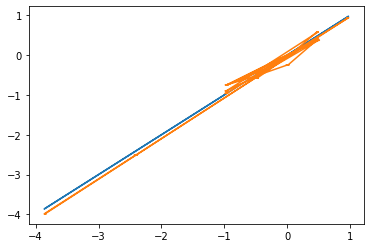

In [281]:
import numpy as np
import matplotlib.pyplot as plt

t=[]
i=[]
q=[]

data = open("donnees-projet-gr1.txt","r")
data = data.read()
data = data.replace('\t','\n')
data = str.split(data)

for k in range (len(data)):
    if k%3==0:
        t.append(data[k])
    elif k%3 == 1 :
        i.append(data[k])
    elif k%3 == 2:
        q.append(data[k])

n = len(q)

for k in range(n):
    t[k], q[k], i[k] = float(t[k]), float(q[k]), float(i[k])


dq = []
di = []

for k in range(n-1):
    dq.append((q[k+1]-q[k])/(t[k+1]-t[k]))
    di.append((i[k+1]-i[k])/(t[k+1]-t[k]))
    
dq.append(dq[-1])
di.append(di[-1])

paliers = [-1]
for k in range(n): 
    if di[k] > 0.1 or di[k] < -0.1 :
        paliers.append(k)
paliers.append(298)

print(f'les paliers sont {paliers}')
dqq=[]

for kk in range(1,len(paliers)) : 
    new_dq = 0
    compteur = 0
    for x in dq[paliers[kk-1]+1:paliers[kk]+1] : 
        new_dq += x
        compteur+=1
    new_dq = new_dq/compteur

    for k in range(paliers[kk-1]+1,paliers[kk]+1):
        dqq.append(new_dq)

Qmax=0
compteur = 0

for k in range(len(dq)):
    if i[k]>0.1 or i[k] < -0.1 : 
        Qmax+=(i[k]/dqq[k])
        compteur+=1
Qmax = Qmax/compteur
    
for k in range(len(dq)):
    dqq[k]*=Qmax
    dq[k]*=Qmax

plt.plot(i,i)
plt.plot(i,dqq)

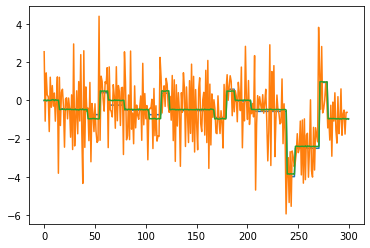

In [285]:
plt.plot(t,dqq,dq)
plt.plot(t,i)